#  Model Selection and Training

In the previous notebook, we selected the Random Forest algorithm. In this notebook, we will fine-tune the model using cross-validation and then train in on the whole training set.

Random Forest is prone to overfitting, as we already noted during algorithm selection. We will use regularization to overcome this problem. 

#### Load training set

In [1]:
import sys
sys.path.insert(0,'/Users/Armin/Desktop/MyFirstMLOps/auto-mpg/')

In [2]:
import pandas as pd
from src.utils import data_path

df_train = pd.read_pickle(data_path("processed", "train_processed.pkl"))
X_train = df_train.drop("mpg", axis=1)
y_train = df_train["mpg"]

## Hyperparameter finetuning 

RandomizedSearchCV is a good alternative for model selection and hyperparameter tuning. RandomisedSearchCV yields to the same results as GridSearchCV in a fraction of time of what would take GridSearchCV. [[Bergstra-Bengio-2013]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)


In [3]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from src.train import report_best_cv_scores

rf = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
param_dist = {
    "max_depth": [3, None],
    "max_features": sp_randint(2, X_train.shape[1] + 1),
    "min_samples_split": sp_randint(2, 10),
    "bootstrap": [True, False],
}
# RandomizedSearchCV maximizses the scores so we use negative mean squared error
neg_mse = make_scorer(mean_squared_error, greater_is_better=False)
n_iter_search = 100
rf_random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    scoring=neg_mse,
    iid=False,
    return_train_score=True,
    verbose=True,
    random_state=42,
    n_jobs=-1,
)

rf_random_search.fit(X_train, y_train)

report_best_cv_scores(rf_random_search.cv_results_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished
/Users/Armin/opt/miniconda3/envs/MLOps/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best model scores
Mean validation RMSE: 3.013 (std: 1.635)
Mean train RMSE: 1.490 (std: 0.453)


The best model found by RandomizedSearch is overfitting the training set. Here is where regularization comes in handy.

## Regularization


RandomsSeachCV tries to maximize the validation without taking care of overfitting.
The best model given by RandomSearch is simply the model with the lowest validation error.

One way to reduce overfitting of Random Forest is to limit the depth of the trees.

In this section, we will find the optimal `max_depth` parameter to reduce overfitting.
We start from the best hyperparameters found by RandomSearchCV and use learning curves to find the optimal value for `max_depth`.


### Learning curves

In [4]:
import numpy as np
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(
    n_estimators=100,
    bootstrap=True,
    max_features=3,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
)

max_depths = np.arange(1, 51, 1, dtype=int)
params = {"max_depth": max_depths}

rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=neg_mse,
    return_train_score=True,
    iid=False,
)

rf_cv.fit(X_train, y_train)

# get training and validation scores
validation_scores = -rf_cv.cv_results_["mean_test_score"]
train_scores = -rf_cv.cv_results_["mean_train_score"]

print("Validation RMSE: {:.3f}".format(np.sqrt(validation_scores).mean()))
print("Train RMSE: {:.3f}".format(np.sqrt(train_scores).mean()))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   42.8s finished
/Users/Armin/opt/miniconda3/envs/MLOps/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Validation RMSE: 3.080
Train RMSE: 1.668


#### Plot learning curves
For the visualization, we use Mean Squared Error (MSE) because it symply accessed from the results of GridSearchCV. It is the same as RMSE.  

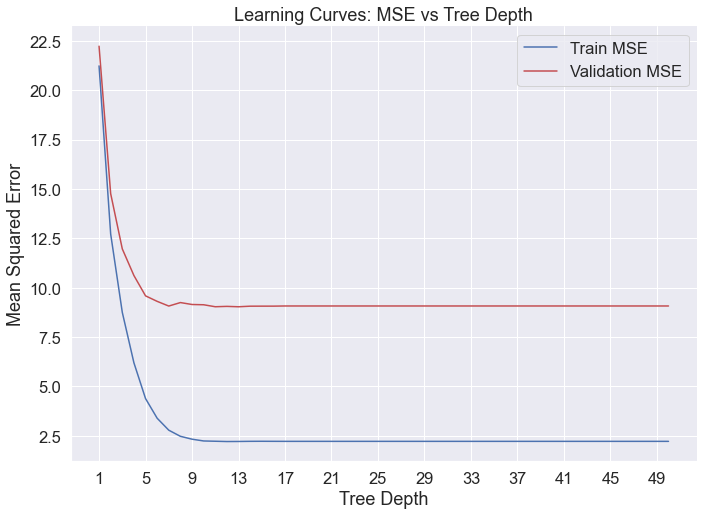

In [5]:
# Imports for vizualisation
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns

sns.set(font_scale=1.5)
# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

figsize(10, 8)
plt.plot(max_depths, train_scores, "b", label="Train MSE")
plt.plot(max_depths, validation_scores, "r", label="Validation MSE")
plt.xticks(np.arange(min(max_depths), max(max_depths) + 1, 4.0))
plt.ylabel("Mean Squared Error")
plt.xlabel("Tree Depth")
plt.grid(True)
plt.title("Learning Curves: MSE vs Tree Depth")
plt.legend()
sns.despine()

We want to minimize the gap between training error and validation error. From the graphic, we can see that `max_depth` of 5 is a good value. 
Even it does not minimize the error on the validation set, it minimizes overfiting and will probably generalize better to unseen data. 

In [6]:
rf_cv.best_params_

{'max_depth': 13}

As we stated previously, for GridSearch the best values for parameters are the ones that minimize errors on the validation set. Here, it is `max_depth` of 13.

## Model Training 

Finally, we train the selected model on the entire training set.
We also drop the feature Asia from the training set. 

In [7]:
from time import time

rf = RandomForestRegressor(
    max_depth=5,
    n_estimators=100,
    bootstrap=True,
    max_features=3,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
)

start = time()
rf.fit(X_train, y_train)
print("Training the Random Forest took {:.2f} seconds".format(time() - start))

Training the Random Forest took 0.41 seconds


#### Save the trained model 

In [8]:
from src.utils import pickle_model

pickle_model(rf, "random_forest.pkl")